In [1]:
import pandas as pd

In [2]:
lat = pd.read_csv('./data/lattice_2d_sample.csv')

In [3]:
free = pd.read_csv('./data/freeform_2d_sample.csv')

In [4]:
lat.head()

,Unnamed: 0,symmetry,unit_cell_x_pixels,unit_cell_y_pixels,geometry_full,condition,C11,C12,C22,C16,C26,C66,CM0_E,CM0_nu\t,CM1_E,CM1_nu,youngs,poisson
0,0,C2v,50,50,1111111111111111111111111111111111111111111111...,Plane Strain,9.062324e+07,2.093444e+06,9.062324e+07,0,0,8.830993e+04,1.000000e-09,NaN,2240000000,0.492537,[90574880.33650465 89842899.57835576 87626117....,[0.02310052 0.03099533 0.05490454 0.09546772 0...
1,1,C2v,50,50,1111111111111111111111111111111111111111111111...,Plane Strain,1.824748e+08,8.405606e+06,1.824748e+08,0,0,6.593863e+05,1.000000e-09,NaN,2240000000,0.492537,[1.82087603e+08 1.80591781e+08 1.76065804e+08 ...,[0.04606448 0.05390091 0.07761197 0.1177657 0...
2,2,C2v,50,50,1111111111111111111111111111111111111111111111...,Plane Strain,2.759388e+08,1.907220e+07,2.759388e+08,0,0,2.265031e+06,1.000000e-09,NaN,2240000000,0.492537,[2.74620541e+08 2.72338812e+08 2.65441965e+08 ...,[0.06911752 0.0768519 0.10023018 0.13973822 0...
3,3,C2v,50,50,1111111111111111111111111111111111111111111111...,Plane Strain,3.713755e+08,3.429137e+07,3.713755e+08,0,0,5.550608e+06,1.000000e-09,NaN,2240000000,0.492537,[3.68209214e+08 3.65133014e+08 3.55845612e+08 ...,[0.0923361 0.09991916 0.12281332 0.16141215 0...
4,4,C2v,50,50,1111111111111111111111111111111111111111111111...,Plane Strain,3.713755e+08,3.429137e+07,3.713755e+08,0,0,5.550608e+06,1.000000e-09,NaN,2240000000,0.492537,[3.68209214e+08 3.65133014e+08 3.55845612e+08 ...,[0.0923361 0.09991916 0.12281332 0.16141215 0...


# Lattice test

In [5]:
from sklearn.neighbors import KernelDensity


In [6]:
x = list(lat['C11'])

In [7]:
y = list(lat['C12'])

In [8]:
def kde2D(x, y, bandwidth, xbins=100j, ybins=100j, **kwargs): 
    """Build 2D kernel density estimate (KDE)."""

    # create grid of sample locations (default: 100x100)
    xx, yy = np.mgrid[min(x):max(x):xbins, 
                      min(y):max(y):ybins]

    xy_sample = np.vstack([yy.ravel(), xx.ravel()]).T
    xy_train  = np.vstack([y, x]).T

    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(xy_train)

    # score_samples() returns the log-likelihood of the samples
    z = np.exp(kde_skl.score_samples(xy_sample))
    return xx, yy, np.reshape(z, xx.shape)

<Figure size 1000x600 with 0 Axes>

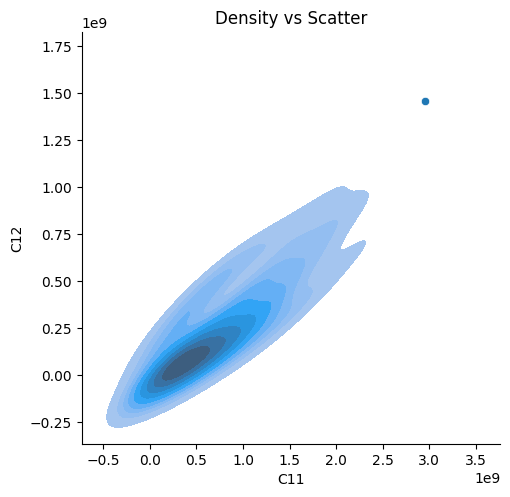

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sample data

# Create a 2D KDE plot
# plt.figure(figsize=(10,6))

# sns.kdeplot(x=x, y=y)
# sns.relplot(x='C11', y='C12', data=lat)


# Display the plot
plt.figure(figsize=(10,6))
sns.relplot(x='C11', y='C12', data=lat)
sns.kdeplot(x=lat.C11, y=lat.C12, fill=True)
# sns.kdeplot(x=free.C11, y=free.C12, fill=True)
plt.title('Density vs Scatter');

In [10]:
def in_box(towers, bounding_box):
    return np.logical_and(np.logical_and(bounding_box[0] <= towers[:, 0],
                                         towers[:, 0] <= bounding_box[1]),
                          np.logical_and(bounding_box[2] <= towers[:, 1],
                                         towers[:, 1] <= bounding_box[3]))

In [11]:
def dataMirror(towers, bounding_box, perc=.1):
    # Select towers inside the bounding box
    i = in_box(towers, bounding_box)
    # Mirror points
    points_center = towers[i, :]
    points_left = np.copy(points_center)
    points_left[:, 0] = bounding_box[0] - (points_left[:, 0] - bounding_box[0])
    points_right = np.copy(points_center)
    points_right[:, 0] = bounding_box[1] + (bounding_box[1] - points_right[:, 0])
    points_down = np.copy(points_center)
    points_down[:, 1] = bounding_box[2] - (points_down[:, 1] - bounding_box[2])
    points_up = np.copy(points_center)
    points_up[:, 1] = bounding_box[3] + (bounding_box[3] - points_up[:, 1])
    points = np.append(points_center,
                       np.append(np.append(points_left,
                                           points_right,
                                           axis=0),
                                 np.append(points_down,
                                           points_up,
                                           axis=0),
                                 axis=0),
                       axis=0)

    # Trim mirrored frame to withtin a 'perc' pad
    xr, yr = np.ptp(towers.T[0]) * perc, np.ptp(towers.T[1]) * perc
    xmin, xmax = bounding_box[0] - xr, bounding_box[1] + xr
    ymin, ymax = bounding_box[2] - yr, bounding_box[3] + yr
    msk = (points[:, 0] > xmin) & (points[:, 0] < xmax) &\
        (points[:, 1] > ymin) & (points[:, 1] < ymax)
    points = points[msk]

    return points.T



In [12]:
def KDEplot(ax, xmin, xmax, ymin, ymax, values):
    # Gaussian KDE.
    kernel = gaussian_kde(values, bw_method=.2)
    # Grid density (number of points).
    gd_c = complex(0, 500)
    # Define x,y grid.
    x_grid, y_grid = np.mgrid[xmin:xmax:gd_c, ymin:ymax:gd_c]
    positions = np.vstack([x_grid.ravel(), y_grid.ravel()])
    # Evaluate kernel in grid positions.
    k_pos = kernel(positions)

    ext_range = [xmin, xmax, ymin, ymax]
    kde = np.reshape(k_pos.T, x_grid.shape)

    ax.imshow(np.rot90(kde), cmap=plt.get_cmap('RdYlBu_r'), extent=ext_range)

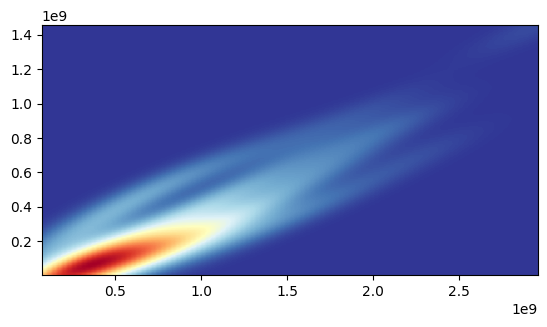

In [13]:
#non-mirror
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Create a 2D Gaussian KDE object
kernel = gaussian_kde(np.vstack([x, y]), bw_method='scott')

# Create a grid of points where we want to evaluate the KDE
xmin, xmax = min(x), max(x)
ymin, ymax = min(y), max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]

# Grid density (number of points).
gd_c = complex(0, 100)
x_grid, y_grid = np.mgrid[xmin:xmax:gd_c, ymin:ymax:gd_c]
positions = np.vstack([x_grid.ravel(), y_grid.ravel()])
k_pos = kernel(positions)


ext_range = [xmin, xmax, ymin, ymax]
kde = np.reshape(k_pos.T, x_grid.shape)
im = plt.imshow(np.rot90(kde), cmap=plt.get_cmap('RdYlBu_r'), extent=ext_range)

plt.show()
# # Evaluate the KDE on the grid
# zz = kde(np.vstack([xx.flatten(), yy.flatten()]))

# # Plot the result as an image
# plt.imshow(zz.reshape(xx.shape), origin='lower', aspect='auto',
#            extent=[xmin, xmax, ymin, ymax], cmap='viridis')

# plt.colorbar(label='Density')
# plt.xlabel('C11')
# plt.ylabel('C12')
# plt.title('2D KDE Plot')

# # Display the plot
# plt.show()

In [14]:
xmax

2957458810.0

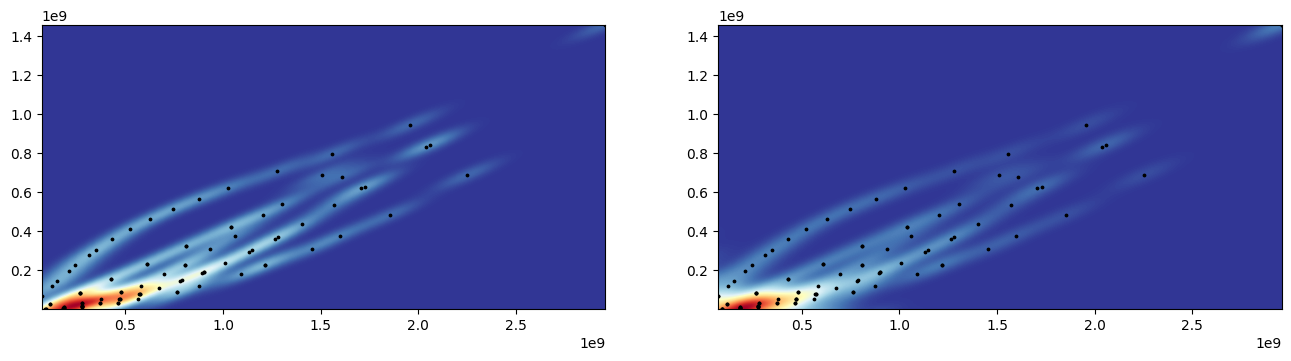

In [17]:
fig, axs = plt.subplots(1,2,figsize=(16,6))

#mirorr
xmin, xmax = min(x), max(x) 
ymin, ymax = min(y), max(y) 
values = np.vstack([x, y])

#Plot non-mirrored data
# plt.subplot(121)
KDEplot(axs[0], xmin, xmax, ymin, ymax, values)
axs[0].scatter(*values, s=3, c='k')
axs[0].axis(xmin=xmin,xmax=xmax, ymin=ymin, ymax=ymax)

# axs[0].xlim(xmin, xmax)
# axs[0].ylim(ymin, ymax)

# Plot mirrored data
bounding_box = (xmin, xmax, ymin, ymax)
values = dataMirror(values.T, bounding_box)
# plt.subplot(122)
KDEplot(axs[1], xmin, xmax, ymin, ymax, values)
axs[1].scatter(*values, s=3, c='k')
axs[1].axis(xmin=xmin,xmax=xmax, ymin=ymin, ymax=ymax)

# plt.xlim(xmin, xmax)
# plt.ylim(ymin, ymax)

plt.show()

In [16]:
bw_used = kde.factor * np.array([x, y]).std(ddof=1)
print("Bandwidth used:", bw_used)

AttributeError: 'numpy.ndarray' object has no attribute 'factor'

In [ ]:
data = np.vstack([lat["C11"], lat["C12"]]).T


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut
from sklearn.neighbors import KernelDensity

bandwidths = range(240510128, 240520128)
grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                    {'bandwidth': bandwidths},
                    cv=LeaveOneOut())
# grid.fit(np.array([x, y]))
grid.fit(data)

In [ ]:
best_bandwidth = grid.best_params_['bandwidth']
print(f"Optimal Bandwidth: {best_bandwidth}")